In [127]:
from math import ceil
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from basis_expansions import NaturalCubicSpline
from dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
concrete = pd.read_excel('Concrete_Data.xls')

In [3]:
concrete.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
column_names_raw = concrete.columns
print(column_names_raw)

Index([u'Cement (component 1)(kg in a m^3 mixture)',
       u'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       u'Fly Ash (component 3)(kg in a m^3 mixture)',
       u'Water  (component 4)(kg in a m^3 mixture)',
       u'Superplasticizer (component 5)(kg in a m^3 mixture)',
       u'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       u'Fine Aggregate (component 7)(kg in a m^3 mixture)', u'Age (day)',
       u'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


In [5]:
column_names = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'finite_aggregate',
    'age',
    'compressive_strength',
]
concrete.columns = column_names

In [6]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,finite_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## EDA

In [7]:
def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('standardizer', StandardScaler()),
        ('nat_cubic', NaturalCubicSpline(-2, 2, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

In [8]:
def plot_univariate_smooth(ax, x, y, x_lim=None, mask=None, smooth=True, n_knots=6, bootstrap=False):
    
    if mask is not None:
        x, y = x[mask], y[mask]
    
    if not x_lim:
        x_lim = (np.min(x), np.max(x))
        
    ax.scatter(x, y, color='grey', alpha=0.25)
    
    if smooth:
        if bootstrap:
            for _ in range(bootstrap):
                x_boot, y_boot = resample(x, y)
                plot_smoother(ax, x_boot, y_boot, 
                              x_lim, n_knots, 
                              alpha=0.5, color="lightblue")        
        plot_smoother(ax, x, y, x_lim, n_knots, 
                      linewidth=3, color="blue")
        
def plot_smoother(ax, x, y, x_lim, n_knots, **kwargs):
    ncr = make_natural_cubic_regression(n_knots)
    ncr.fit(x, y)
    t = np.linspace(x_lim[0], x_lim[1], num=250)
    y_smoothed = ncr.predict(t.reshape(-1, 1))
    ax.plot(t, y_smoothed, **kwargs)

/Users/matthew.drury/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


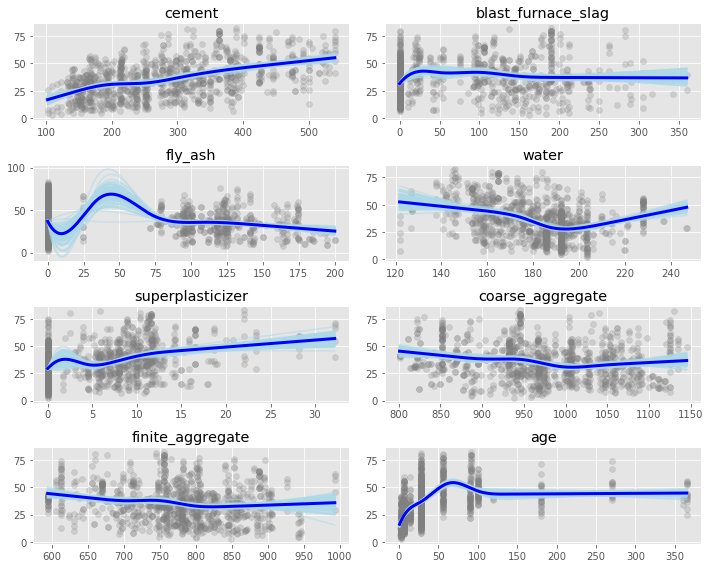

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))
univariate_plot_names = concrete.columns[:-1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax, 
                           concrete[name].values.reshape(-1, 1),
                           concrete['compressive_strength'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

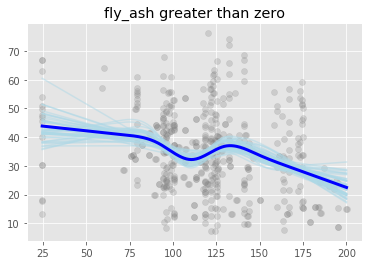

In [10]:
fig, ax = plt.subplots()
plot_univariate_smooth(
    ax,
    concrete['fly_ash'].values.reshape(-1, 1), 
    concrete['compressive_strength'], 
    bootstrap=50,
    mask=(concrete['fly_ash'] > 0))
ax.set_title("fly_ash greater than zero")

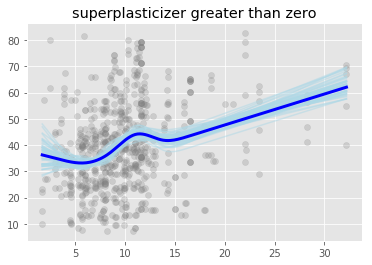

In [11]:
fig, ax = plt.subplots()
plot_univariate_smooth(
    ax,
    concrete['superplasticizer'].values.reshape(-1, 1), 
    concrete['compressive_strength'], 
    mask=(concrete['superplasticizer'] > 0),
    bootstrap=50)
ax.set_title("superplasticizer greater than zero")

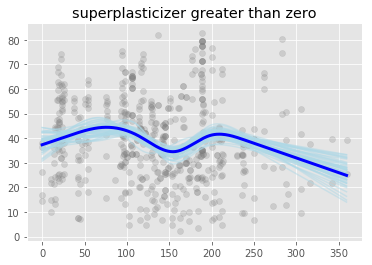

In [12]:
fig, ax = plt.subplots()
plot_univariate_smooth(
    ax,
    concrete['blast_furnace_slag'].values.reshape(-1, 1), 
    concrete['compressive_strength'], 
    mask=(concrete['blast_furnace_slag'] > 0),
    bootstrap=50)
ax.set_title("superplasticizer greater than zero")

## How Will We Treat These Varaibles in Regression

### Cement

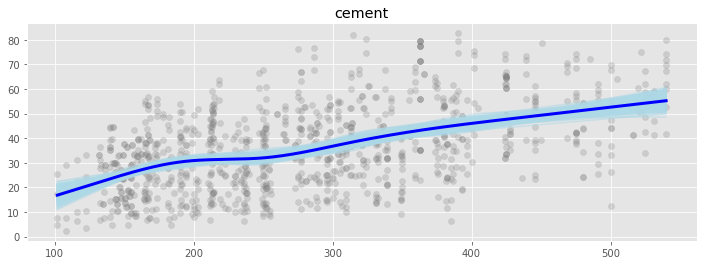

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['cement'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title("cement")

There is not much evidence that fitting anything other than a line is justified, so lets go with the simplest possible fit.

In [43]:
cement_fit = Pipeline([
    ('cement', ColumnSelector(name='cement')),
    ('passthrough', Identity())
])

### Blast Furnace Slag

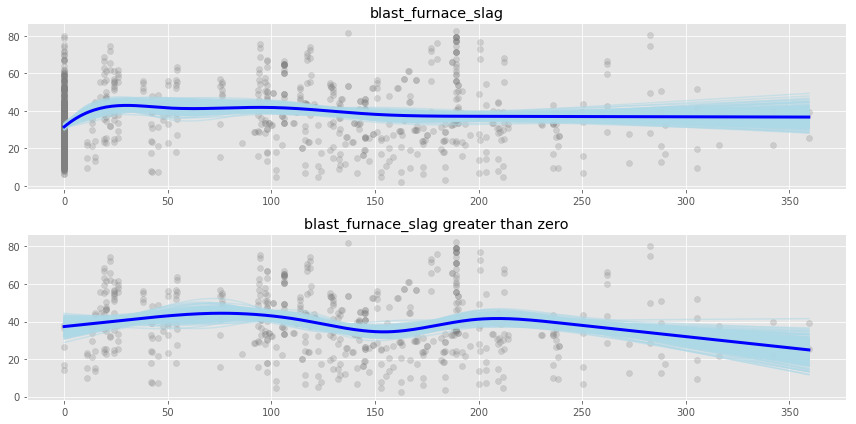

In [81]:
fig, axs = plt.subplots(2, figsize=(12, 6))
plot_univariate_smooth(
    axs[0],
    concrete['blast_furnace_slag'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
axs[0].set_title("blast_furnace_slag")

plot_univariate_smooth(
    axs[1],
    concrete['blast_furnace_slag'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    mask=(concrete['blast_furnace_slag'] > 0),
    bootstrap=200)
axs[1].set_title("blast_furnace_slag greater than zero")
fig.tight_layout()

There is a lot of data with value zero, and this seems to be associated with a lower value of `y` than would otherwise be expected.  The rest of the data shows little or no trend.

Taking these into account, we will fit this feature using two parameters:

  - An indicator varaible for `blast_furnace_slag == 0`.
  - A linear fit to capture the, possibly slight, effect of blast furnace slage being non-zero.
  
This also brings up an interesting **inferential** question that we may want to study in the future: is the effect of `blast_furnace_slag` non-zero?

In [42]:
slag_fit = Pipeline([
    ('slag', ColumnSelector(name='blast_furnace_slag')),
    ('slag_features', FeatureUnion([
        ('zero_slag', MapFeature(lambda slag: slag == 0.0, 'zero_slag')),
        ('slag', Identity())  
    ]))
])

### Fly Ash

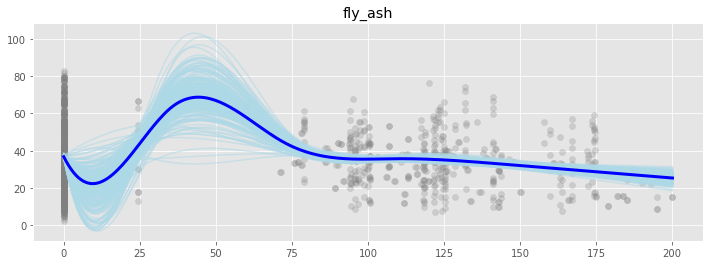

In [65]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['fly_ash'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title("fly_ash")

Another similar case to the `blast_furnace_slag`, there is a stong cluster of records with a value of zero.  

There is not much evidence for anything more complicated than linear variation in the large cluster of data to the right of the plot (in the `>= 75` reigon).

The small cluster at `25` seems innocent, but the are *high leverage* points.  If we leave them unattended to, they may exhibit a large effect on the slope of the regression line we hope to fit to the rest of the data.  For this reason, we will also add an indicator varaible for `fly_ash == 25.0`.

In [60]:
fly_ash_fit = Pipeline([
    ('fly_ash', ColumnSelector(name='fly_ash')),
    ('fly_ash_features', FeatureUnion([
        ('zero_fly_ash', MapFeature(lambda ash: ash == 0.0, 'zero_fly_ash')),
        ('twenty_five_fly_ash', MapFeature(
            lambda ash: (ash >= 24.0) & (ash <= 26.0), 'twenty_five_fly_ash')),
        ('fly_ash', Identity())  
    ]))
])

### Water

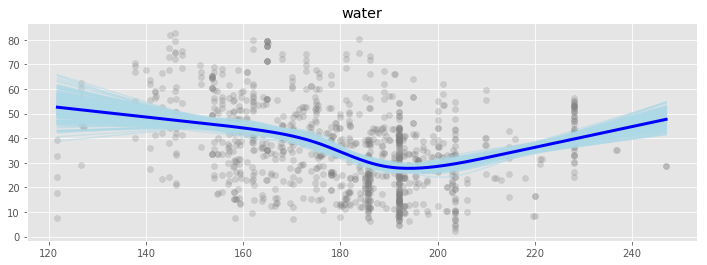

In [67]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['water'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title('water')

Water is an interesting feature.  It looks like too little water harms the compressive strength of a concrete, as does too mych water, with a perfect level somewhere in the middle.  It looks like the engeneers *know* this, as evidenced by the large accumulation of points at around `190`, which is very close to the sweet spot.

We would like to capture this trend, which requires three degrees of freedom, and hence three knots (you can convince yourself of this by playing with the smoothers app.

In [68]:
water_fit = Pipeline([
    ('water', ColumnSelector(name='water')),
    ('water_spline', NaturalCubicSpline(knots=[170, 190, 210]))
])

### Superplasticizer

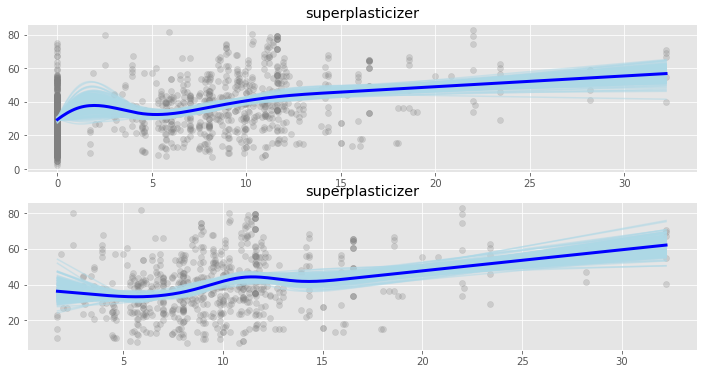

In [84]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_univariate_smooth(
    axs[0],
    concrete['superplasticizer'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
axs[0].set_title('superplasticizer')

plot_univariate_smooth(
    axs[1],
    concrete['superplasticizer'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    mask=(concrete['superplasticizer'] > 0),
    bootstrap=200)
axs[1].set_title('superplasticizer')

Here, again, we need an indicator varaible for the many records which assume that value zero.

For the non-zero records, it looks like there may be some non-linearity in the trend, flatter ...

### A Possible Issue

### Constructing All the Features

In [69]:
feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('cement_fit', cement_fit),
    ('slag_fit', slag_fit),
    ('fly_ash_fit', fly_ash_fit),
    ('water_fit', water_fit)
])

In [70]:
feature_pipeline.fit(concrete)
features = feature_pipeline.transform(concrete)

In [85]:
features.head()

,intercept,cement,zero_slag,blast_furnace_slag,zero_fly_ash,twenty_five_fly_ash,fly_ash,water_spline_linear,water_spline_0
0,1.0,540.0,1.0,0.0,1.0,0.0,0.0,162.0,0.0
1,1.0,540.0,1.0,0.0,1.0,0.0,0.0,162.0,0.0
2,1.0,332.5,0.0,142.5,1.0,0.0,0.0,228.0,2280.0
3,1.0,332.5,0.0,142.5,1.0,0.0,0.0,228.0,2280.0
4,1.0,198.6,0.0,132.4,1.0,0.0,0.0,192.0,265.8


### Fit a Regression and Look at the Coefficients

In [93]:
model = LinearRegression(fit_intercept=False)
model.fit(features.values, y=concrete['compressive_strength'], )

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [104]:
def display_coef(model, coef_names):
    print("{:<25}{:<20}".format("Name", "Parameter Estimate"))
    print("-"*(25 + 20))
    for coef, name in zip(model.coef_, coef_names):
        row = "{:<25}{:<20}".format(name, coef)
        print(row)

In [105]:
display_coef(model, features.columns)

Name                     Parameter Estimate  
---------------------------------------------
intercept                60.4957547035       
cement                   0.105636077053      
zero_slag                1.15700458185       
blast_furnace_slag       0.086396015466      
zero_fly_ash             -6.24225587477      
twenty_five_fly_ash      7.45506196954       
fly_ash                  0.0165086358279     
water_spline_linear      -0.337851372298     
water_spline_0           0.00774880996599    


### Bootstrap to Get a Feel for How the Coefficients Vary

In [133]:
def bootstrap_train(model, X, y, bootstraps=1000, **kwargs):
    bootstrap_coefs = np.empty(shape=(bootstraps, X.shape[1]))
    for i in range(bootstraps):
        boot_idxs = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_boot = X[boot_idxs, :]
        y_boot = y[boot_idxs]
        M = model(**kwargs)
        M.fit(X_boot, y_boot)
        bootstrap_coefs[i, :] = M.coef_
    return bootstrap_coefs

In [134]:
bootstrap_coefs = bootstrap_train(
    LinearRegression, features.values, concrete['compressive_strength'],
    fit_intercept=False
)

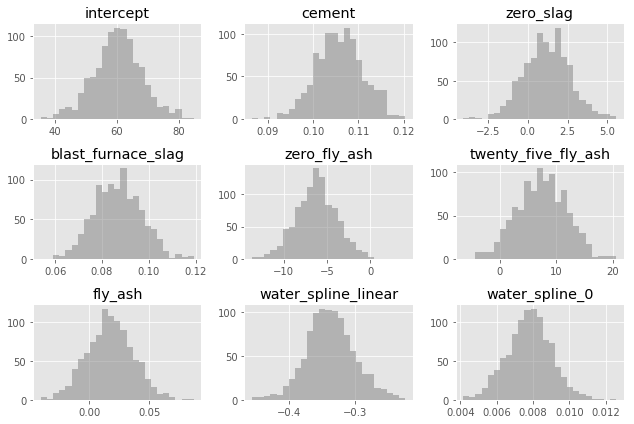

In [138]:
def plot_bootstrap_coefs(bootstrap_coefs, coef_names, n_col=3):
    n_coeffs = bootstrap_coefs.shape[1]
    n_row = int(ceil(n_coeffs / n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*2))
    for idx, ax in enumerate(axs.flatten()):
        ax.hist(bootstrap_coefs[:, idx], bins=25, color="grey", alpha=0.5)
        ax.set_title(coef_names[idx])
    return fig, axs

fig, axs = plot_bootstrap_coefs(bootstrap_coefs, features.columns)
fig.tight_layout()